# El problema de la mochila

Se tiene una mochila y un conjunto de artículos con diferente peso y valor. Se intenta determinar que artículos se pueden colocar adentro de la mochila de manera que no se sobrepase el límite de peso de la mochila maximizando el valor total. 

Resolver el problema agregando heurística para los siguientes artículos y un límite de 30kg:

<table style="font-size:16px">
    <tr>
        <th>Item</th><td>Valor</td><td>Peso</td>
    </tr>
    <tr>
        <th>A</th><td>4</td><td>12</td>
    </tr>
    <tr>
        <th>B</th><td>2</td><td>2</td>
    </tr>
    <tr>
        <th>C</th><td>10</td><td>4</td>
    </tr>
    <tr>
        <th>D</th><td>1</td><td>1</td>
    </tr>
    <tr>
        <th>E</th><td>5</td><td>15</td>
    </tr>
    <tr>
        <th>F</th><td>3</td><td>2</td>
    </tr>
    <tr>
        <th>G</th><td>14</td><td>7</td>
    </tr>
    <tr>
        <th>H</th><td>4</td><td>10</td>
    </tr>
</table>

## Codificación

- Definir como se codificará el problema

## Adaptación

- Definir como se calculará la adaptación de un individuo
- ¿Existen estados que deben ser penalizados?


In [1]:
import numpy
import random
import matplotlib
import matplotlib.pyplot as plt

def generar_poblacion(num_pop):
    poblacion = numpy.zeros(shape=(num_pop, 8))
    
    for i in range(0, num_pop): 
        poblacion[i] = numpy.random.permutation([i for i in range(0,8)])
    
    return poblacion.astype(int)

#equation_inputs : valores de entrada
#pop : población
def cal_pop_fitness(population):
    fitness = []
    articulos = ["A", "B", "C", "D", "E", "F", "G", "H", "Vacio"]
    pesos = [12, 2, 4, 1, 15, 2, 7, 10, 0]
    valores = [4, 2, 10, 1, 5, 3, 14, 4, 0]
    
    for pop in population:
        #penalizar ciudades repetidas
        penalizar = False
        
        kg = 0
        valor = 0
        rvp = 0
        i = 0
        
        #se recorren los articulos
        for item2 in range(len(pop)-1):
            #se suman las relaciones valor peso
            kg = kg + pesos[pop[i]]
            valor = valor + valores[pop[i]]
            i=i+1
        
        rvp = valor/kg
        
        #aplicar la inversa (adaptacion)
        adaptacion= 1/rvp  
        
        if len(pop) != len(set(pop)) or kg > 30:
            adaptacion = adaptacion * -9999999 
            
        fitness.append(adaptacion)
    
    return fitness


## Selección

In [2]:

#pop: población
#fitness: arreglo con los valores de adaptación
#num_parent: cantidad de padres que se quieren obtener
def select_mating_pool(pop, fitness, num_parents):
    ranking = [0] * len(fitness)
    prob = []
    
    for rank in range(len(fitness), 0, -1):
        #indice de mayor valor
        ranking[fitness.index(max(fitness))] = rank
        fitness[fitness.index(max(fitness))] = -99999999
    
    for i in range(0, len(ranking)):
        prob.append(ranking[i] / (len(ranking) * (len(ranking) - 1 )))
    
    prob = numpy.array(prob)
    
    prob /= prob.sum()
        
    parents = numpy.random.choice(pop.shape[0], size = num_parents,  p = prob)
    
    lista = [pop[indice] for indice in parents]
    
    return lista

## Cruza

In [3]:
def arreglar_gen(hijo):
    if len(hijo) != len(set(hijo)):
        hijo = list(set(hijo))
        res = list(set([i for i in range(1,11)]) - set(hijo))
        for i in res:
            hijo.append(i)
    return hijo

#parents: lista de padres
#offspring_size: cantidad de hijos que se quieren obtener
def crossover(parents, offspring_size):    
    
    lista = [2, 3, 4, 5, 6, 7]
    offspring1 = []
    offspring2 = []
    
    #Generar arreglo vacío donde se guardarán los hijos
    offspring = []
    
    #Definir punto de cruce en la mitad de los padre 
    crossover_point = numpy.sort(numpy.array(random.sample(lista, 2)))
    
    for k in range(0, offspring_size, 2):
        # Índice del primer padre para realizar la cruza
        parent1_idx = k%parents.shape[0]
        # Índice del segundo padre para realizar la cruza
        parent2_idx = (k+1)%parents.shape[0]
        # Generar la primera parte del primer hijo
        offspring1[0:crossover_point[0]] = parents[parent1_idx, 0:crossover_point[0]]
        # Generar la segunda parte del primer hijo
        offspring1[crossover_point[0]:] = parents[parent2_idx, crossover_point[0]:crossover_point[1]]
        # Generar la tercera parte del primer hijo
        offspring1[crossover_point[1]:] = parents[parent1_idx, crossover_point[1]:]
        # Generar la primera parte del segundo hijo
        offspring2[0:crossover_point[0]] = parents[parent2_idx, 0:crossover_point[0]]
        # Generar la segunda parte del segundo hijo
        offspring2[crossover_point[0]:] = parents[parent1_idx, crossover_point[0]:crossover_point[1]]
        # Generar la tercera parte del segundo hijo
        offspring2[crossover_point[1]:] = parents[parent2_idx, crossover_point[1]:]
        
        offspring.append(offspring1)
        offspring.append(offspring2)
    
    #Devolver lista de hijos
    return offspring

## Mutación

In [4]:
#offspring_crossover: lista de hijos a mutar
def mutation(offspring_crossover):
    #print("Offspring Crossover: ", offspring_crossover)
    listapos = [i for i in range(0,len(offspring_crossover[0]))]
    
    for idx in range(len(offspring_crossover)):
        replacepos = random.sample(listapos, 2)
        
        # Reemplazar el valor de dos genes por dos valores aleatorios
        aux = offspring_crossover[idx][min(replacepos)] 
        offspring_crossover[idx][min(replacepos)] = offspring_crossover[idx][max(replacepos)]
        offspring_crossover[idx][max(replacepos)] = aux
    
    #Devolver lista de hijos mutados
    return offspring_crossover

# Algoritmo

In [5]:
#Cantidad de genes
num_genes = 10
#Soluciones por población
sol_per_pop = 200
#Número de padres para cruza
num_parents_mating = 20
#Tamaño de la población
pop_size = (sol_per_pop, num_genes)
#Crear pobliación inicial con valores aleatorios
new_population = generar_poblacion(sol_per_pop)
#Cantidad de generaciones a realizar
num_generations = 200

-9999999.0
0
-7777776.999999999
1
-7777776.999999999
2
-7777776.999999999
3
-7777776.999999999
4
-7777776.999999999
5
-7586206.137931035
6
-7586206.137931035
7
-6999999.3
8
-6999999.3
9
-6999999.3
10
-8571427.714285715
11
-8571427.714285715
12
-8529410.911764707
13
-7027026.324324324
14
-5833332.75
15
-5833332.75
16
-5833332.75
17
-5833332.75
18
-6999999.3
19
-4651162.325581395
20
-4651162.325581395
21
-4651162.325581395
22
-4651162.325581395
23
-4651162.325581395
24
-4651162.325581395
25
-5441175.926470588
26
-5441175.926470588
27
-5441175.926470588
28
-4358973.923076923
29
-4358973.923076923
30
-4189188.7702702703
31
-4189188.7702702703
32
-4189188.7702702703
33
-4189188.7702702703
34
-4189188.7702702703
35
-3999999.6
36
-3999999.6
37
-3999999.6
38
-4189188.7702702703
39
-4189188.7702702703
40
-4189188.7702702703
41
-3999999.6
42
-3999999.6
43
-3999999.6
44
-3999999.6
45
-3999999.6
46
-3999999.6
47
-3999999.6
48
-3999999.6
49
-3999999.6
50
-3999999.6
51
-3999999.6
52
-3999999.6
53
-3

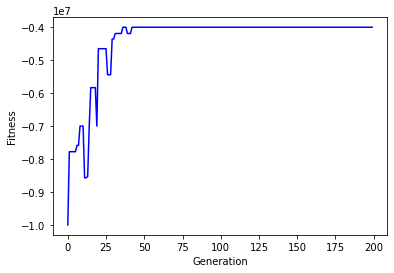

In [6]:
gen = []
fit = []
best_adaptation = -99999999
best_match = []

for generation in range(num_generations):
    # Obtener valores de adaptación de la población
    fitness = cal_pop_fitness(new_population)
    # Selección
    parents = select_mating_pool(new_population, fitness, 
                                      num_parents_mating)
    
    parents = numpy.array(parents)
    
    # Cruza
    offspring_crossover = crossover(parents,
                                       offspring_size=(pop_size[0] - parents.shape[0]))
    
    # Mutación
    offspring_mutation = mutation(offspring_crossover)
    offspring_mutation = numpy.array(offspring_mutation)
    
    
    # Crear nueva población basada en los padres y los hijos
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    # Obtener mejor resultado para la generación
    fit.append(numpy.max(cal_pop_fitness(new_population)))
    print(numpy.max(cal_pop_fitness(new_population)))
    gen.append(generation)
    print(generation)
    
    if best_adaptation < numpy.max(cal_pop_fitness(new_population)):
        best_adaptation = numpy.max(cal_pop_fitness(new_population))
        best_match_idx = numpy.where(cal_pop_fitness(new_population) == numpy.max(cal_pop_fitness(new_population)))
        best_match = new_population[best_match_idx, :]

#Obtener la mejor solución
print("Mejor resultado : ", best_match)
print("Adaptación del mejor resultado : ", best_adaptation)

#Gráfico
fig, ax = plt.subplots()
ax.plot(gen, fit, 'b')
ax.set_ylabel('Fitness')
ax.set_xlabel('Generation')
plt.show()

"""
    La poblacion inicial se deberia generar de forma distinta
    para que existan poblacion con menos de 30 kg.
"""